# High-level APIs: tests and plots
This notebook demonstrates three high-level APIs in `ecoindex.pca_evaluation`:

1) `run_assessment_suite(X, labels, ...)` — runs 5 analyses and returns a compact summary for tables.
2) `plot_permanova_null_distribution(X, labels, ...)` — plots the F null distribution.
3) `plot_directional_null_distribution(X, labels, ref, deg, ...)` — plots the directional one-sided null.

In [419]:
# Setup and imports
import os, sys, importlib, json
import numpy as np
import pandas as pd

PROJECT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import ecoindex
ecoindex = importlib.reload(ecoindex)
from ecoindex import (
    prepare_feature_matrix,
    build_groups_from_labels,
    build_groups_from_quantiles,
    run_assessment_suite,
    plot_permanova_null_distribution,
    plot_directional_null_distribution,
)
print('ecoindex file:', ecoindex.__file__)

ecoindex file: /Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/__init__.py


## Load example data
Loads the processed `master_pollution_rank.csv` with MultiIndex columns (block, subblock, var).

In [420]:
csv_path = os.path.join(DATA_DIR, 'master_pollution_rank.csv')
master = pd.read_csv(csv_path, header=[0,1,2], index_col=0)
master.index.name = 'StationID'
if isinstance(master.columns, pd.MultiIndex) and master.columns.nlevels == 3:
    master.columns = pd.MultiIndex.from_tuples(master.columns, names=['block','subblock','var'])
print('master shape:', master.shape)
master.head(2)

master shape: (104, 107)


block      chemical                                                      \
subblock        raw                                                       
var         1234TCB   1245TCB    Al     As     Bi     Ca      Cd     Co   
StationID                                                                 
A10        0.835583  0.775732  3041  1.939  18.45  28170  0.2950  2.723   
A23        0.639983  0.697265  4483  2.512  17.03  42110  0.3986  4.009   

block                     ...                                    pollution  \
subblock                  ...      logz           sumreal_by_logz_chemical   
var            Cr     Cu  ...     ppDDE total_PCB                  SumReal   
StationID                 ...                                                
A10         8.766  17.64  ... -0.343200 -0.397416                -1.991195   
A23        10.850  17.28  ...  0.137696  0.365410                 3.665201   

block                                                                \
subblock                                            2006_rank         
var       Quality SumReal_Shuffled Quality_Shuffled      Rank  rank   
StationID                                                             
A10        medium        -4.856084        reference      54.0  14.0   
A23        medium         2.214899         degraded      79.0  38.0   

block                         
subblock                      
var          Quality SumReal  
StationID                     
A10        reference    14.0  
A23           medium    38.0  

[2 rows x 107 columns]

## Build features (X) and labels
We prefer chemical/logz features; fall back to raw. For labels, use existing pollution Quality if present; else use SumReal quantiles (bottom/middle/top).

In [421]:
# Choose features
try:
    X, idx = prepare_feature_matrix(master, 
                                    block='chemical', 
                                    subblock='logz', 
                                    variables=None, 
                                    standardize=True)
    feat_block, feat_sub = 'chemical', 'logz'
except Exception:
    X, idx = prepare_feature_matrix(master, block='chemical', subblock='raw', variables=None, standardize=True)
    feat_block, feat_sub = 'chemical', 'raw'

var_names = list(master[(feat_block, feat_sub)].columns)

# Choose labels
try:
    labels = build_groups_from_labels(master,
                                      pollution_block='pollution', 
                                      pollution_subblock='sumreal_by_logz_chemical', 
                                      label_var='Quality').reindex(idx).values
except Exception:
    labels = build_groups_from_quantiles(master, pollution_block='pollution', pollution_subblock='sumreal_by_logz_chemical', score_var='SumReal').reindex(idx).values

print('X shape:', X.shape, '| labels:', len(labels))

X shape: (104, 30) | labels: 104


/Users/gufeng/2025_winter/Thesis_Project/ThesisProject/Project/src/ecoindex/pca_evaluation.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub = master[(block, subblock)]
/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_8309/1518974627.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  var_names = list(master[(feat_block, feat_sub)].columns)


## 1) Generate test summary table
Use `run_assessment_suite` with features and labels to compute 5 results and display a compact table.

In [422]:
suite = run_assessment_suite(X, labels)

In [423]:
# Reorganize suite results into a cleaner dataframe
results = []

# PERMANOVA results
perm = suite['perm_direct']
results.append({
    'Test': 'PERMANOVA',
    'Statistic': perm['F'],
    'p_value': perm['p'],
    'R_squared': perm['R2'],
    'df_between': perm['df_between'],
    'df_within': perm['df_within'],
    'n_permutations': perm['n_perm'],
    'Additional_Info': f"Method: {perm['method']}"
})

# Directional Average results
dir_avg = suite['dir_avg']
results.append({
    'Test': 'Directional (Average)',
    'Statistic': dir_avg['stat'],
    'p_value': dir_avg['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_avg['n_perm'],
    'Additional_Info': f"Mode: {dir_avg['mode']}, Ref: {dir_avg['reference_label']}, Deg: {dir_avg['degraded_label']}"
})

# Directional Minimum results
dir_min = suite['dir_min']
results.append({
    'Test': 'Directional (Minimum)',
    'Statistic': dir_min['stat'],
    'p_value': dir_min['p'],
    'R_squared': None,
    'df_between': None,
    'df_within': None,
    'n_permutations': dir_min['n_perm'],
    'Additional_Info': f"Mode: {dir_min['mode']}, Ref: {dir_min['reference_label']}, Deg: {dir_min['degraded_label']}"
})

# Create comprehensive results dataframe
results_df = pd.DataFrame(results)

# Add summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Null Tail p-value', 'Loss Function'],
    'Value': [suite['perm_null_tail']['p_tail'], suite['loss']],
    'Description': ['One-tailed permutation test p-value', 'Classification loss metric']
})

print("Assessment Suite Results:")
print("=" * 50)
print(results_df.to_string(index=False))
print("\nAdditional Metrics:")
print("=" * 20)
print(summary_stats.to_string(index=False))

Assessment Suite Results:
                 Test  Statistic  p_value  R_squared  df_between  df_within  n_permutations                              Additional_Info
            PERMANOVA  13.303149    0.002   0.208503         2.0      101.0             499                Method: permutation_euclidean
Directional (Average)   0.968131    0.002        NaN         NaN        NaN             499 Mode: average, Ref: reference, Deg: degraded
Directional (Minimum)  -0.546272    0.624        NaN         NaN        NaN             499     Mode: min, Ref: reference, Deg: degraded

Additional Metrics:
           Metric    Value                         Description
Null Tail p-value 0.002000 One-tailed permutation test p-value
    Loss Function 0.562743          Classification loss metric


In [424]:
results_df

,Test,Statistic,p_value,R_squared,df_between,df_within,n_permutations,Additional_Info
0,PERMANOVA,13.303149,0.002,0.208503,2.0,101.0,499,Method: permutation_euclidean
1,Directional (Average),0.968131,0.002,NaN,NaN,NaN,499,"Mode: average, Ref: reference, Deg: degraded"
2,Directional (Minimum),-0.546272,0.624,NaN,NaN,NaN,499,"Mode: min, Ref: reference, Deg: degraded"


## 2) Plot PERMANOVA F null
Use `plot_permanova_null_distribution` with the same features and labels to visualize the null distribution and observed F.

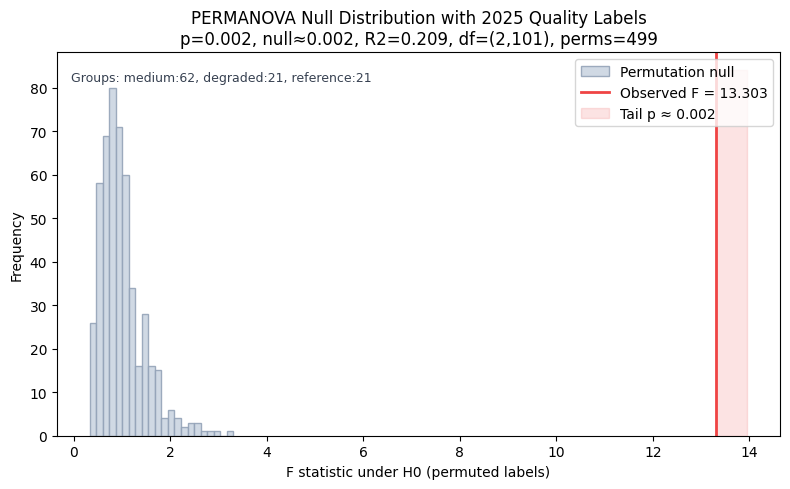

In [425]:
fig_f, ax_f, info_f = plot_permanova_null_distribution(X, labels, permutations=499, seed=0, title='PERMANOVA Null Distribution with 2025 Quality Labels')
# print(info_f)

## 3) Plot directional one-sided null
Use `plot_directional_null_distribution`. If you didn’t specify labels for reference/degraded, we infer them (e.g., 'reference' vs 'degraded' or 'bottom' vs 'top').

{'statistic': 0.968130888258956, 'p_value': 0.002, 'p_tail': 0.002, 'mode': 'average', 'reference_label': 'reference', 'degraded_label': 'degraded', 'n_perm': 499, 'top_vars': ['total_PCB', 'Ca', 'Mn', 'Mg', 'Pb']}


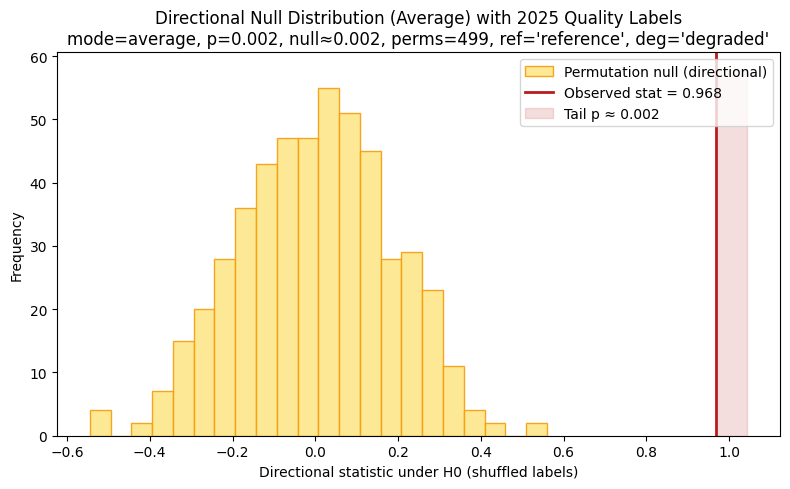

In [426]:
# Infer reference and degraded from labels when not provided
cats = list(pd.Categorical(labels).categories)
ref_candidates = [c for c in cats if str(c).lower().startswith('ref')]
deg_candidates = [c for c in cats if str(c).lower().startswith('deg')]
ref = ref_candidates[0] if ref_candidates else ('bottom' if 'bottom' in cats else min(cats))
deg = deg_candidates[0] if deg_candidates else ('top' if 'top' in cats else max(cats))
fig_d, ax_d, info_d = plot_directional_null_distribution(X, labels, ref, deg, mode='average', permutations=499, standardize=True, var_names=var_names,
                                                         title = "Directional Null Distribution (Average) with 2025 Quality Labels")
print(info_d)

## Visualize the distribution of the pollution scores

In [427]:
master['pollution', '2006_rank']['Quality'].unique()

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_8309/3251457470.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  master['pollution', '2006_rank']['Quality'].unique()


array(['reference', 'medium', 'degraded'], dtype=object)

## Map: Huron–Erie Corridor with Sampling Sites
This section plots the Detroit River and adjacent lakes from shapefiles and overlays site locations from the master table using environmental/raw latitude and longitude.

In [428]:
# Mapping utilities
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

MAPS_DIR = Path(PROJECT_DIR) / 'data' / 'maps'


def plot_rivers_lakes(ax=None, annotating=False):
    """Plot the Detroit River with adjacent lakes and return (fig, ax)."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.figure

    # Read shapefiles
    lake_stclair = gpd.read_file(MAPS_DIR / 'lake_stclair' / 'lake_stclair.shp')
    lake_erie = gpd.read_file(MAPS_DIR / 'lake_erie' / 'lake_erie.shp')
    detroit_river = gpd.read_file(MAPS_DIR / 'detroit_river_aoc_shapefile' / 'AOC_MI_Detroit_2021.shp')
    stclair_river = gpd.read_file(MAPS_DIR / 'aoc_mi_stclair_2021' / 'AOC_MI_StClair_2021.shp')
    lake_huron = gpd.read_file(MAPS_DIR / 'lake_huron' / 'lake_huron.shp')

    # Plot layers
    lake_stclair.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    lake_erie.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    lake_huron.plot(ax=ax, color='lightblue', edgecolor='none', alpha=0.5)
    detroit_river.plot(ax=ax, color='lightblue', edgecolor='none')
    stclair_river.plot(ax=ax, color='lightblue', edgecolor='none')

    ax.set_title('The Huron–Erie Corridor')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_ylim(42.0, 43.2)
    ax.set_xlim(-83.3, -82.3)

    if annotating:
        ax.annotate(
            'Detroit River', xy=(-83.1, 42.3), xytext=(-83.28, 42.4),
            arrowprops=dict(arrowstyle='->', linewidth=1, color='black'),
            fontsize=8, color='blue', weight='bold'
        )
        ax.text(-82.85, 42.42, 'Lake St. Clair', fontsize=8, color='blue', weight='bold')
        ax.annotate(
            'St. Clair River', xy=(-82.5, 42.8), xytext=(-82.95, 42.9),
            arrowprops=dict(arrowstyle='->', linewidth=1, color='black'),
            fontsize=8, color='blue', weight='bold'
        )
        ax.text(-82.55, 42.05, 'Lake Erie', fontsize=8, color='gray', style='italic')
        ax.text(-82.65, 43.1, 'Lake Huron', fontsize=8, color='gray', style='italic')
    return fig, ax

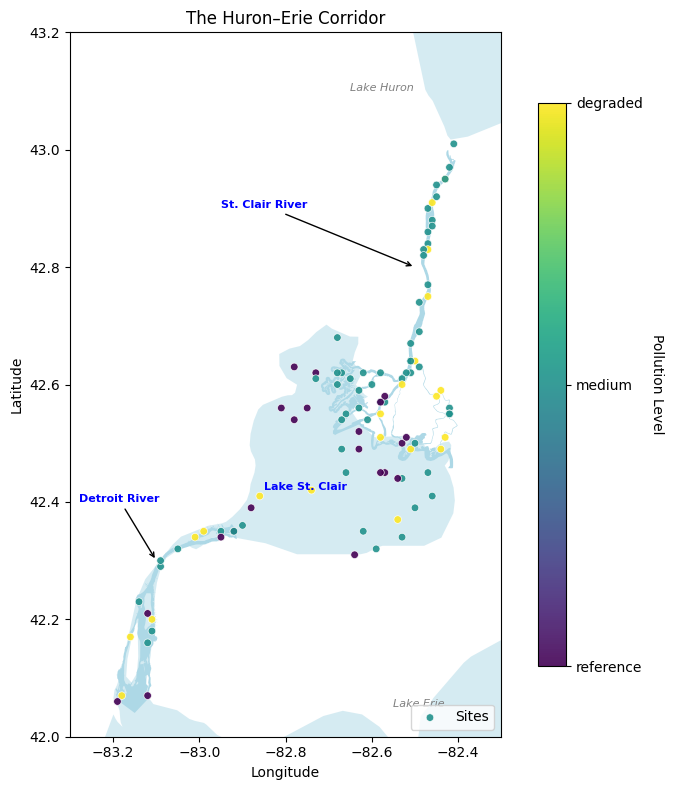

In [429]:
# Color sites by pollution score (Quality)
pollution_col = ('pollution', 'sumreal_by_logz_chemical', 'Quality')
lon_col = ('environmental', 'raw', 'Longitude')
lat_col = ('environmental', 'raw', 'Latitude')

if pollution_col in master.columns:
    # Get coordinates and pollution scores for sites in our analysis
    site_data = master.loc[idx, [lon_col, lat_col, pollution_col]].copy()
    site_data.columns = ['lon', 'lat', 'pollution']
    site_data = site_data.dropna()
    
    fig, ax = plot_rivers_lakes(annotating=True)
    
    # Create meaningful color mapping based on pollution severity
    pollution_order = ['reference', 'medium', 'degraded']  # low to high pollution
    color_map = {cat: i for i, cat in enumerate(pollution_order)}
    numeric_colors = site_data['pollution'].map(color_map)
    
    # Create scatter plot colored by pollution category
    scatter = ax.scatter(site_data['lon'], site_data['lat'], 
                        c=numeric_colors, s=30, 
                        cmap='viridis', edgecolor='white',  # reversed colormap: green=clean, red=polluted
                        linewidth=0.5, alpha=0.9, label='Sites')

    # Add colorbar with meaningful labels
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Pollution Level', rotation=270, labelpad=15)
    cbar.set_ticks(range(len(pollution_order)))
    cbar.set_ticklabels(pollution_order)
    
    ax.legend(loc='lower right')
    plt.tight_layout()
else:
    print('Quality column not found. Please verify column names.')

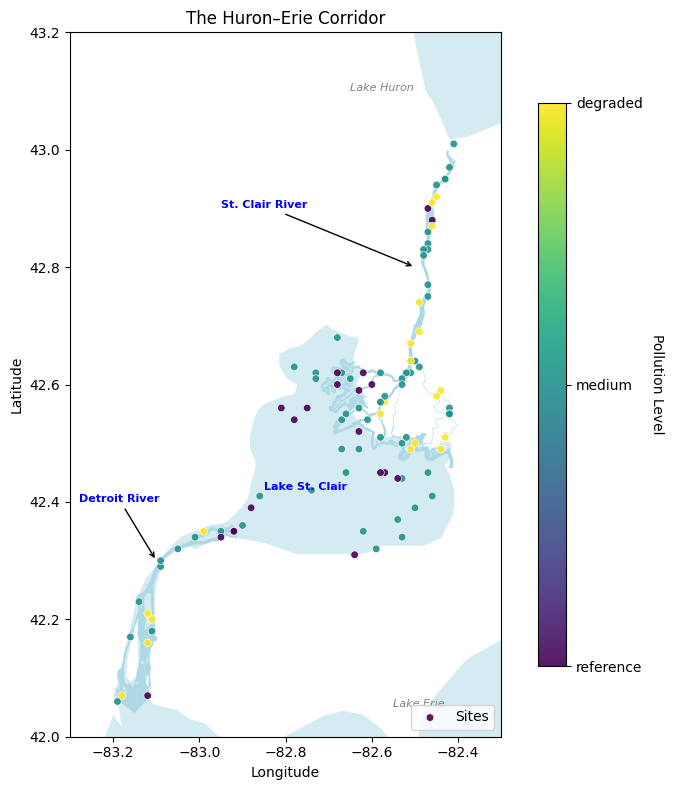

In [430]:
# Color sites by pollution score (Quality)
pollution_col = ('pollution', '2006_rank', 'Quality')
lon_col = ('environmental', 'raw', 'Longitude')
lat_col = ('environmental', 'raw', 'Latitude')

if pollution_col in master.columns:
    # Get coordinates and pollution scores for sites in our analysis
    site_data = master.loc[idx, [lon_col, lat_col, pollution_col]].copy()
    site_data.columns = ['lon', 'lat', 'pollution']
    site_data = site_data.dropna()
    
    fig, ax = plot_rivers_lakes(annotating=True)
    
    # Create meaningful color mapping based on pollution severity
    pollution_order = ['reference', 'medium', 'degraded']  # low to high pollution
    color_map = {cat: i for i, cat in enumerate(pollution_order)}
    numeric_colors = site_data['pollution'].map(color_map)
    
    # Create scatter plot colored by pollution category
    scatter = ax.scatter(site_data['lon'], site_data['lat'], 
                        c=numeric_colors, s=30, 
                        cmap='viridis', edgecolor='white',  # reversed colormap: green=clean, red=polluted
                        linewidth=0.5, alpha=0.9, label='Sites')

    # Add colorbar with meaningful labels
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Pollution Level', rotation=270, labelpad=15)
    cbar.set_ticks(range(len(pollution_order)))
    cbar.set_ticklabels(pollution_order)
    
    ax.legend(loc='lower right')
    plt.tight_layout()
else:
    print('Quality column not found. Please verify column names.')

### Side-by-side maps (two assessments)
The two maps below show the same sites colored by two different assessment results, arranged horizontally for comparison.

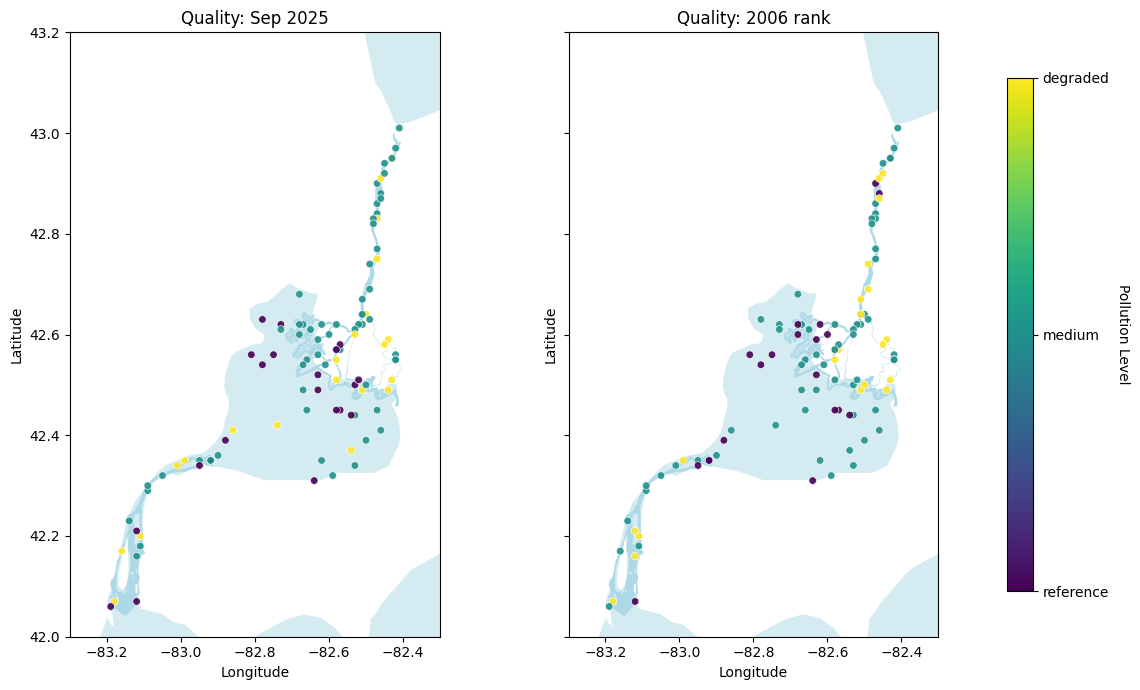

In [431]:
# Combined side-by-side maps with shared y-axis and single colorbar
import numpy as np
from matplotlib.colors import Normalize

# Columns for two assessments
pollution_col_A = ('pollution', 'sumreal_by_logz_chemical', 'Quality')
pollution_col_B = ('pollution', '2006_rank', 'Quality')
lon_col = ('environmental', 'raw', 'Longitude')
lat_col = ('environmental', 'raw', 'Latitude')

# Verify required columns exist
missing = []
for col in [pollution_col_A, pollution_col_B, lon_col, lat_col]:
    if col not in master.columns:
        missing.append(str(col))
if missing:
    print('Missing columns:', ', '.join(missing))
else:
    # Base coordinates for the same analysis subset (idx) and drop rows with missing coords
    coords = master.loc[idx, [lon_col, lat_col]].copy()
    coords.columns = ['lon', 'lat']
    coords = coords.dropna()

    # Pull labels for both assessments aligned to coords
    labA = master.loc[idx, pollution_col_A].reindex(coords.index)
    labB = master.loc[idx, pollution_col_B].reindex(coords.index)

    # Ordered categories and numeric mapping (0,1,2) shared across both panels
    pollution_order = ['reference', 'medium', 'degraded']
    color_map = {cat: i for i, cat in enumerate(pollution_order)}

    # Build per-panel valid masks (drop rows with unknown or NaN labels)
    numA = labA.map(color_map)
    numB = labB.map(color_map)
    maskA = numA.notna()
    maskB = numB.notna()

    # Prepare figure and axes with shared y-axis (and x for consistency)
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, sharex=True)

    # Common normalization and cmap for a single colorbar
    norm = Normalize(vmin=0, vmax=len(pollution_order)-1)
    cmap = 'viridis'

    # Left panel: Assessment A (sumreal_by_logz_chemical|Quality)
    _, axL = plot_rivers_lakes(ax=axes[0], annotating=False)
    scatA = axL.scatter(coords.loc[maskA, 'lon'], coords.loc[maskA, 'lat'],
                        c=numA[maskA], s=30, cmap=cmap, norm=norm,
                        edgecolor='white', linewidth=0.5, alpha=0.9)
    axL.set_title('Quality: Sep 2025')

    # Right panel: Assessment B (2006_rank|Quality)
    _, axR = plot_rivers_lakes(ax=axes[1], annotating=False)
    scatB = axR.scatter(coords.loc[maskB, 'lon'], coords.loc[maskB, 'lat'],
                        c=numB[maskB], s=30, cmap=cmap, norm=norm,
                        edgecolor='white', linewidth=0.5, alpha=0.9)
    axR.set_title('Quality: 2006 rank')

    # One shared colorbar across both axes
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.tight_layout()
    
    cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.85)
    cbar.set_label('Pollution Level', rotation=270, labelpad=15)
    cbar.set_ticks(range(len(pollution_order)))
    cbar.set_ticklabels(pollution_order)

    
    plt.show()